# Importing the necessary libraries

In [1]:


import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline 



# Finding calibration parameters

In [2]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)



In [3]:

# Calibration parameters 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

# Undistorting images function 


In [4]:
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


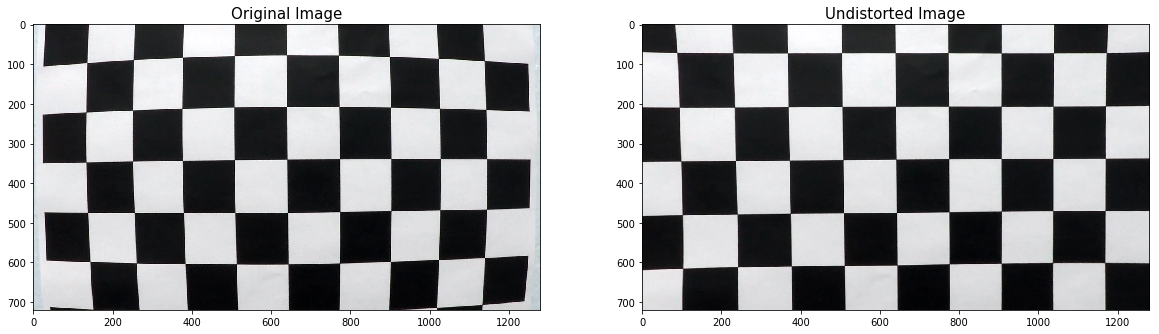

In [5]:
#Testing on one of the chessboard images
Original = cv2.imread(images[0])
Undistorted = cal_undistort(Original, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(Original)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(Undistorted)
ax2.set_title('Undistorted Image', fontsize=15)
plt.savefig('output_images/undistortion.png')

## Sobel Threshold


In [6]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #cv2.Sobel(hls_trans[:,:,2]
    # Return the result
    return binary_output
    


## HLS Saturation Threshold

In [7]:
def hls_thresh (img, thresh_min=90, thresh_max=255):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    thresh = (thresh_min, thresh_max)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

# Testing the HLS & Sobel functions

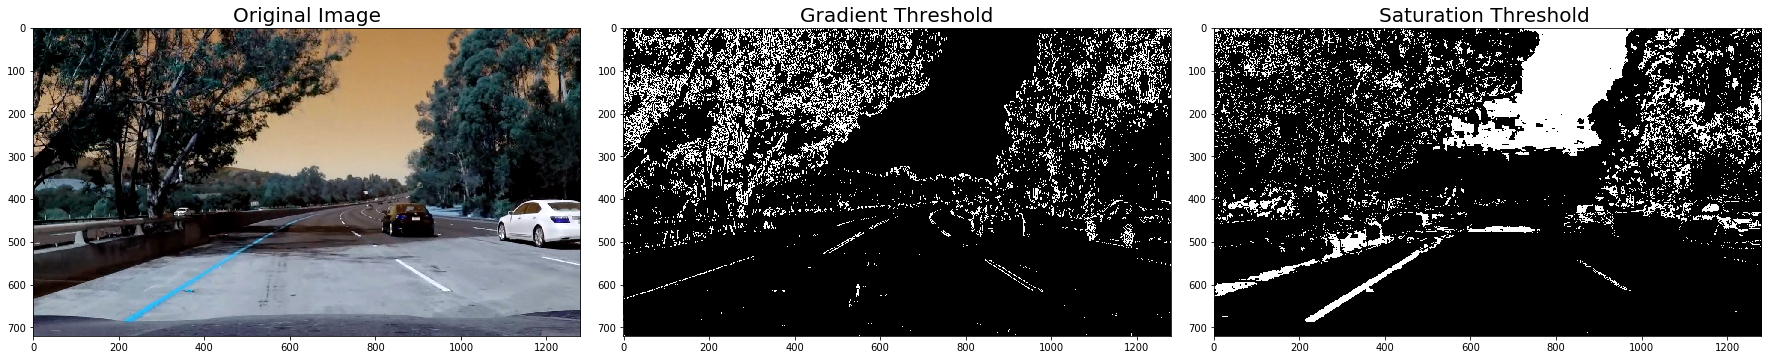

In [8]:
# Make a list of test images
images = glob.glob('test_images/test*.jpg')
# Make an image list
imgList=[]
sobelResult=[]
hlsResult = []
for fname in images:
    imgList.append(cv2.imread(fname))
    
# Run the function
for img in imgList:
    sobelResult.append(abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100))
    hlsResult.append(hls_thresh (img, thresh_min=100, thresh_max=250))
# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imgList[4])
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(sobelResult[4], cmap='gray')
ax2.set_title('Gradient Threshold', fontsize=20)
ax3.imshow(hlsResult[4], cmap='gray')
ax3.set_title('Saturation Threshold ', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


plt.savefig('output_images/sobel_hls.png')

## Perspective transform


In [9]:
def birdView (img, inv = False):
    h,w = img.shape[:2]

    # Source and destination points
#     src = np.float32([(520,500),
#                   (770,500), 
#                   (250,680), 
#                   (1050,680)])
#     dst = np.float32([(200,0),
#                   (w-200,0),
#                   (200,h),
#                   (w-200,h)])
    
    src = np.float32([(590,450),
                  (690,450), 
                  (250,680), 
                  (1050,680)])
    dst = np.float32([(200,0),
                  (w-200,0),
                  (200,h),
                  (w-200,h)])
     
    
    
    if not inv:
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    else:
        Minv = cv2.getPerspectiveTransform(dst,src)
        warped = cv2.warpPerspective(img, Minv, (w,h), flags=cv2.INTER_LINEAR)
    return warped

# Perspective transform test

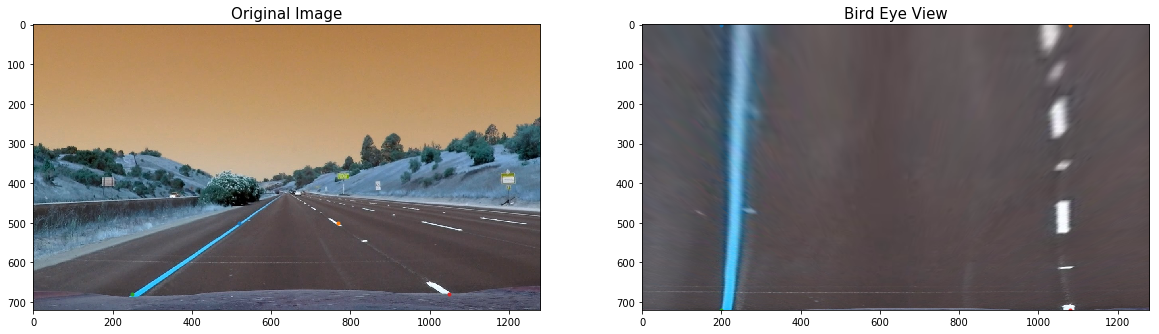

In [10]:


Original = cv2.imread(images[7])
h,w = Original.shape[:2]
warped = birdView(Original)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(520,500,'.')
ax1.plot(770,500,'.')
ax1.plot(250,680,'.')
ax1.plot(1050,680,'.')
ax1.imshow(Original)
ax1.set_title('Original Image', fontsize=15)

ax2.plot(200,0,'.')
ax2.plot(w-200,0,'.')
ax2.plot(200,h,'.')
ax2.plot(w-200,h,'.')
ax2.imshow(warped)
ax2.set_title('Bird Eye View', fontsize=15)

plt.savefig('output_images/bird_view.png')

# Preprocessing pipeline

In [11]:
def pipeline (img):
    #kernel_size =3
    #vertices = np.array([[(1150,0),(100,0), (100,750), (1150,750)]], dtype=np.int32)
    undistortImg = cal_undistort(img, mtx, dist)
    
    warpedImg = birdView(undistortImg)
    #roi = region_of_interest(warpedImg,vertices) 
    xsobel = abs_sobel_thresh(warpedImg, orient='x', thresh_min=20, thresh_max=100)
    hls = hls_thresh (warpedImg, thresh_min=100, thresh_max=250)
    combined = np.zeros_like(xsobel)
    combined[(xsobel == 1) | (hls == 1)] = 1
    
    
    return combined
    

## Preprocessing Pipeline Test

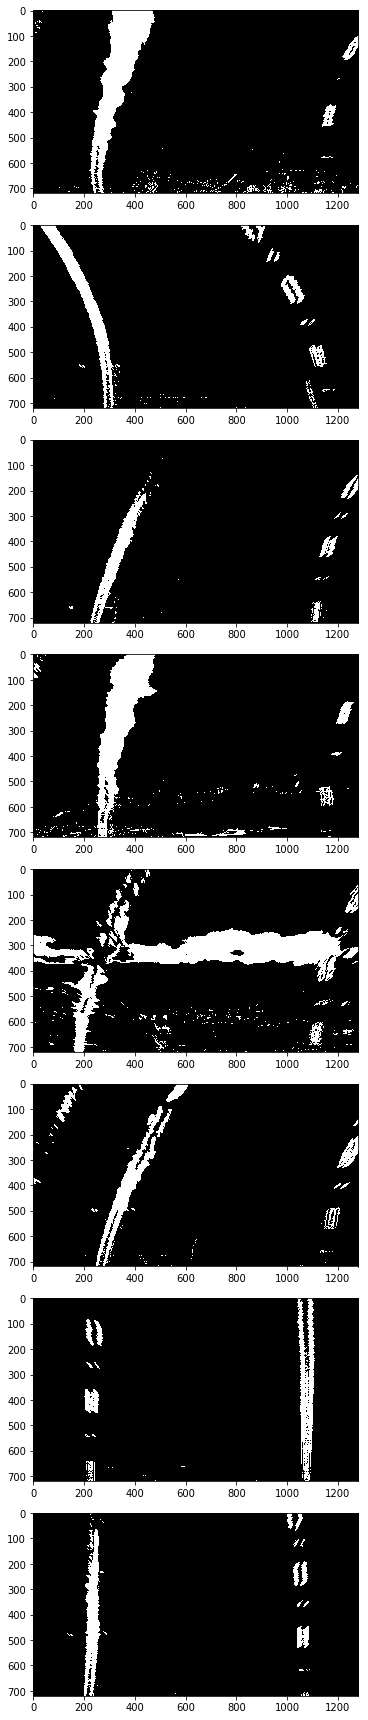

In [12]:
# Make a list of test images
images = glob.glob('test_images/test*.jpg')
# Make an image list
imgList=[]
for fname in images:
    imgList.append(cv2.imread(fname))
    
#Pipeline Test
pipeOutput=[]
for img in imgList:
    pipeOutput.append(pipeline(img))
# Plot the result
f, (axs) = plt.subplots(8, 1, figsize=(24,24))
f.tight_layout()
for i in range(0,8):
    axs[i].imshow(pipeOutput[i], cmap = "gray")
       
    
plt.savefig('output_images/preprocess.png')

# Finiding the Lanes


## Sliding window & Polynomial fit  

In [13]:
def laneFit (binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Calculate raduis of curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ly_eval = np.max(lefty)
    ry_eval = np.max(righty)
    # Fit new polynomials to x,y in world space
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*ly_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*ry_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #coloring the lanes (Red for left & Blue for right)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return  {'left':left_fit, 'right':right_fit, 'out_img':out_img, 'leftrad':left_curverad, 'rightrad':right_curverad}

# Sliding window visualisation

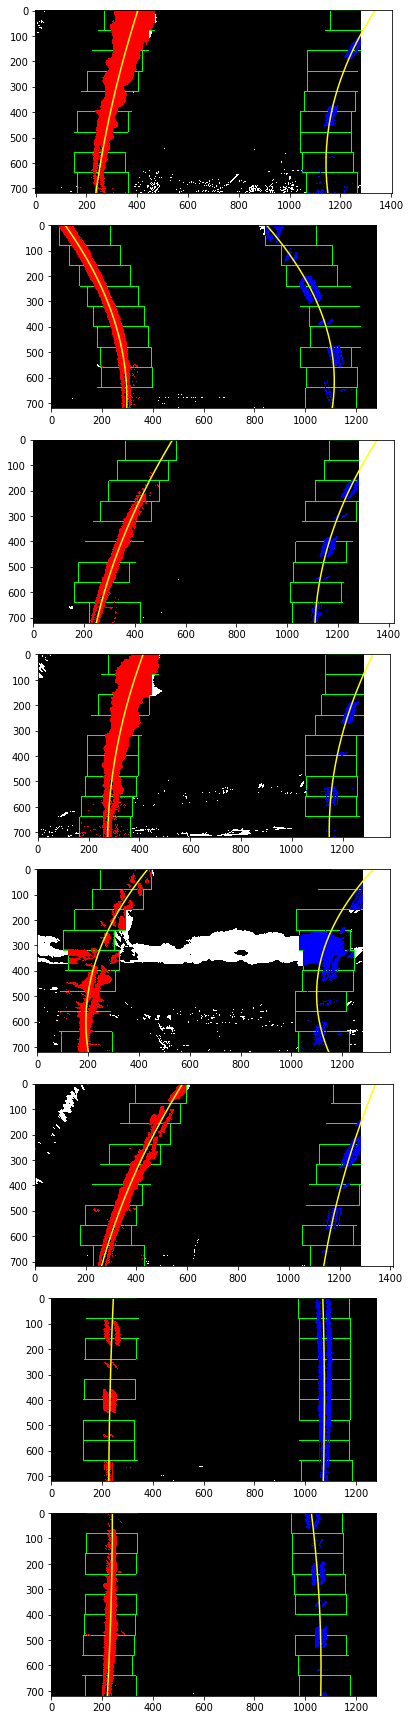

In [14]:
# Plot the result
f, (axs) = plt.subplots(8, 1, figsize=(24,24))
f.tight_layout()
i=0
for img in pipeOutput:
    
    fitted = laneFit(img)
    left_fit = fitted['left']
    right_fit = fitted['right']
    out_img = fitted['out_img']
    #Preparing visualisation
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    axs[i].imshow(out_img)
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
    i+=1
plt.savefig('output_images/sliding.png')

In [15]:
def laneFit_prev(binary_warped,left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return {'left':left_fit, 'right':right_fit}

# Complete Process


In [16]:
def process_img (img):
    binary_warped = pipeline(img)
    #if not left_lane.detected or not right_lane.detected:
    fit = laneFit(binary_warped)
       # left_lane.detected, right_lane.detected = True, True
    #else:
     #   fit = laneFit_prev(binary_warped,left_lane.best_fit, right_lane.best_fit)
    
    
    left_fit = fit['left']
    left_curverad = fit['leftrad']
    
    right_fit = fit['right']
    right_curverad = fit['rightrad']
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]          
    # Distance from center
    leval =   left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]  
    reval =   right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]
    lanes_center = (leval + reval)/ 2
    dst_cen = (lanes_center - img.shape[1] /2) * (3.7/700) # meters per pixel in x dimension
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = birdView(color_warp,True) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    #CAlculate curvature
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    
    
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_curverad),(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(right_curverad),(50,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    if dst_cen > 0:
        cv2.putText(result,'The car is %.2f m left of center'%(abs(dst_cen)),(50,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(result,'The car is %.2f m right of center'%(abs(dst_cen)),(50,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return result

# Testing the final Process

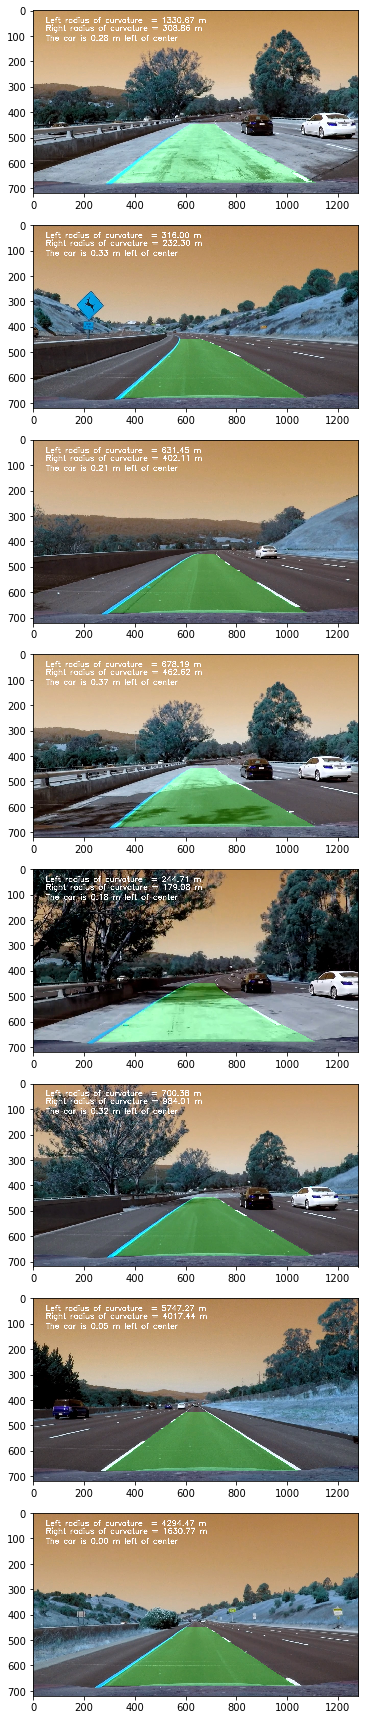

In [17]:
# Make a list of test images
images = glob.glob('test_images/test*.jpg')
# Make an image list
imgList=[]
for fname in images:
    imgList.append(cv2.imread(fname))
    
#Pipeline Test
#right_lane = Line()
#left_lane = Line()
result=[]
for img in imgList:
    result.append(process_img(img))
# Plot the result
f, (axs) = plt.subplots(8, 1, figsize=(24,24))
f.tight_layout()
for i in range(0,8):
    axs[i].imshow(result[i])
plt.savefig('output_images/final.png')       

# Video processing


In [18]:
#right_lane = Line()
#left_lane = Line()
video_output = 'video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
result_video = video_input.fl_image(process_img)
%time result_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video video_output.mp4
[MoviePy] Writing video video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:32<00:00,  8.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output.mp4 

Wall time: 2min 33s


# Challenge video 

In [20]:


video_output = 'challenge_output.mp4'
video_input = VideoFileClip('challenge_video.mp4')
result_video = video_input.fl_image(process_img)
%time result_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:53<00:00,  8.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

Wall time: 54.8 s


# Harder challenge

In [ ]:
# right_lane = Line()
# left_lane = Line()
# video_output = 'harder_output.mp4'
# video_input = VideoFileClip('harder_challenge_video.mp4')
# result_video = video_input.fl_image(process_img)
# %time result_video.write_videofile(video_output, audio=False)